In [2]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import os
import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import matplotlib.ticker as ticker


In [3]:
is_div_path = r'C:\\Users\\yedidyab\\Downloads\\dv_new\\is_div_pairs.csv'

pairs_df = pd.read_csv(is_div_path)
# Melting the dataframe to combine idx1 and idx2 into a single 'cell_id' column
pairs_melted_df = pd.melt(pairs_df, id_vars=['Unnamed: 0', 'idx1_fov', 'is_dividing', 'log_proba'],
                    value_vars=['idx1', 'idx2'],
                    var_name='cell_type',
                    value_name='cell_id')

# Dropping the 'cell_type' column as it is not necessary
pairs_melted_df.drop(columns=['cell_type', 'log_proba','Unnamed: 0'], inplace=True)
pairs_melted_df.rename(columns={'idx1_fov': 'field_of_view'}, inplace=True)
pairs_melted_df['field_of_view'] = 'fov_' + pairs_melted_df['field_of_view'].astype(str)


pairs_melted_df


,field_of_view,is_dividing,cell_id
0,fov_27,1.0,874
1,fov_27,1.0,2046
2,fov_27,1.0,2284
3,fov_27,1.0,1358
4,fov_27,1.0,1097
...,...,...,...
88667,fov_36,0.0,1410
88668,fov_36,0.0,323
88669,fov_36,0.0,1354
88670,fov_36,0.0,1363


In [21]:



# Initialize an empty DataFrame to hold all the gene data across libraries
combined_df = pd.DataFrame()

# Loop through all the libraries and load the data
for lib in range(0, 45):
    cell_by_gene_path = rf'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\cell_by_gene\\lib_{lib}_lib_{lib}_cell_by_gene.norm.txt'
    # if lib == 4:
    #     break

    if os.path.exists(cell_by_gene_path):
        df = pd.read_csv(cell_by_gene_path, sep='\t')

        # Add a column to distinguish the data from different libraries if necessary
        df['library'] = lib

        # Combine the current DataFrame with the aggregated DataFrame
        combined_df = pd.concat([combined_df, df], axis=0)
        print(f'add lib {lib}')


# Merge with is_div_data on appropriate columns (assuming a common key is present)
df_norm = combined_df.merge(pairs_melted_df, on=['cell_id','field_of_view'], how='left')  # Replace 'cell_id' with actual key column


# Assuming 'cell_length' exists in all dataframes
lower_bound = df_norm['cell_length'].quantile(0.05)
upper_bound = df_norm['cell_length'].quantile(0.95)

# Filter the dataframe to include only the cells within the 5th and 95th percentiles
df_norm = df_norm[(df_norm['cell_length'] >= lower_bound) & (df_norm['cell_length'] <= upper_bound)]

# Normalize all gene expressions by cell length
genes = df_norm.columns[7:-1]  # All columns after 'cell_length' except the 'library' column

for gene in genes:
    df_norm[gene] = df_norm[gene] / df_norm['cell_length']

# Bin the cells based on length into 7 bins, then manually set the bin for is_div == 1
df_norm['length_bin'] = pd.qcut(df_norm['cell_length'], q=7, labels=False)
df_norm.loc[df_norm['is_dividing'] == 1, 'length_bin'] = 7

# Create a vector of the means of the bins for each gene
gene_medians = df_norm.groupby('length_bin')[genes].mean()

df_norm.to_csv('df_norm.csv')
gene_medians.to_csv('gene_med.csv')

add lib 1
add lib 2
add lib 3
add lib 4
add lib 5
add lib 6
add lib 7
add lib 8
add lib 9
add lib 10
add lib 11
add lib 12
add lib 13
add lib 14
add lib 15
add lib 16


C:\Users\yedidyab\AppData\Local\Temp\ipykernel_10180\3063074894.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm['length_bin'] = pd.qcut(df_norm['cell_length'], q=7, labels=False)


In [35]:


gene_medians = df_norm.groupby('length_bin')[genes].mean()
#
# # Step 1: Compute the median of each gene across all bins
gene_median_across_bins = gene_medians.mean()
#
# # Step 2: Filter the DataFrame and the gene list
gene_medians = gene_medians.loc[:, gene_median_across_bins > 1]


# Step 3: Update the 'genes' list to include only the genes with median >= 30
filtered_genes = [gene for gene in genes if gene_median_across_bins[gene] > 1]



# Update the original 'genes' list if needed
genes = filtered_genes

gene_medians = gene_medians[genes]

# made cluster 0 the start point
gene_medians +=1
gene_medians = gene_medians / gene_medians.iloc[0]
#################################################################################################
# epsilon = 1e-10  # A small value to avoid division by zero
#
# # df_norm.iloc[:, 7:-2] = df_norm.iloc[:, 7:-2] / (gene_medians.iloc[0] + epsilon)
# gene_medians = gene_medians / (gene_medians.iloc[0] + epsilon)

#################################################################################################
# # Normalize the vectors (gene medians) before classification
# scaler = StandardScaler()
# gene_medians_normalized = pd.DataFrame(scaler.fit_transform(gene_medians_min_subtracted.T), columns=gene_medians.index, index=genes)
gene_medians_normalized = gene_medians

# Perform KMeans clustering to classify the vectors into different expression patterns
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(gene_medians_normalized.T)

# Create a DataFrame to store the cluster labels for each gene
gene_clusters = pd.DataFrame({
    'gene': gene_medians.columns,
    'cluster': kmeans.labels_
})

# Create directories for each cluster
output_dir = r'C:\\Users\\yedidyab\\Downloads\\\cluster_no_scale_by_cluster_0_5k_over_1_mean_rat_v3'
for cluster in gene_clusters['cluster'].unique():
    cluster_dir = os.path.join(output_dir, f'cluster_{cluster}')
    os.makedirs(cluster_dir, exist_ok=True)

# Loop through each gene and create a plot
for gene in genes:
    plt.figure(figsize=(6, 10))

    # Filter the DataFrame to include only values below or equal to the 95th percentile    # Calculate the 95th percentile for the gene
    p95 = df_norm[gene].quantile(0.95)
    df_filtered = df_norm[df_norm[gene] <= p95]

    # Plot the boxplots with a single color
    sns.boxplot(x='length_bin', y=gene, data=df_filtered, color="skyblue")

    # Overlay the dots on the boxplot
    sns.stripplot(x='length_bin', y=gene, data=df_filtered, color="red", alpha=0.5, jitter=.2, size=1)  # Adds jitter to avoid overlap

    # Draw the median line
    median_vals = df_norm.groupby('length_bin')[gene].median()
    plt.plot(median_vals, color="black", marker="o", linestyle="--", label='Median')

    plt.title(f'Expression of {gene} across different cell length bins')
    plt.xlabel('Cell Length Bins')
    plt.ylabel(f'Normalized Expression of {gene}')
    # plt.legend()

    # Save the plot in the appropriate cluster directory
    cluster_label = gene_clusters[gene_clusters['gene'] == gene]['cluster'].values[0]
    plot_path = os.path.join(output_dir, f'cluster_{cluster_label}', f'{gene}_expression.png')
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()  # Close the plot to save memory


# Generate overlay plots for each cluster
cluster_colors = sns.color_palette("husl", len(gene_clusters['cluster'].unique()))  # Generate distinct colors for each cluster

for cluster in gene_clusters['cluster'].unique():
    plt.figure(figsize=(12, 8))

    cluster_genes = gene_clusters[gene_clusters['cluster'] == cluster]['gene'].values
    color = cluster_colors[cluster]

    for gene in cluster_genes:
        plt.plot(gene_medians.index, gene_medians_normalized[gene], label=gene, color=color)

    plt.title(f'Overlay of Gene Expression Vectors for Cluster {cluster}')
    plt.xlabel('Cell Length Bins')
    plt.ylabel('Expression Level (Min-Subtracted)')
    plt.legend(loc='upper right', fontsize='small', ncol=2)

    # Save the overlay plot in the corresponding cluster directory
    overlay_plot_path = os.path.join(output_dir, f'cluster_{cluster}', f'cluster_{cluster}_overlay.png')
    plt.savefig(overlay_plot_path)
    plt.close()

# Plot all cluster overlays together with different colors
plt.figure(figsize=(14, 10))

for cluster in gene_clusters['cluster'].unique():
    cluster_genes = gene_clusters[gene_clusters['cluster'] == cluster]['gene'].values
    color = cluster_colors[cluster]

    for gene in cluster_genes:
        plt.plot(gene_medians.index, gene_medians_normalized[gene], label=f'Cluster {cluster}', color=color, alpha=0.7)

plt.title('Combined Overlay of Gene Expression Vectors by Cluster')
plt.xlabel('Cell Length Bins')
plt.ylabel('Expression Level (Min-Subtracted)')
# plt.legend(loc='upper right', fontsize='small', ncol=2)

# Save the combined overlay plot
combined_overlay_plot_path = os.path.join(output_dir, 'combined_cluster_overlay.png')
plt.savefig(combined_overlay_plot_path)
plt.close()



Plots, overlay plots, and combined overlay saved to their respective directories.
      gene  cluster
0  pre_16s        0
1     ackA        1
2     cheA        0
3     rpoS        2
4     rpsC        0


C:\Users\yedidyab\Anaconda3\envs\piplnew\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


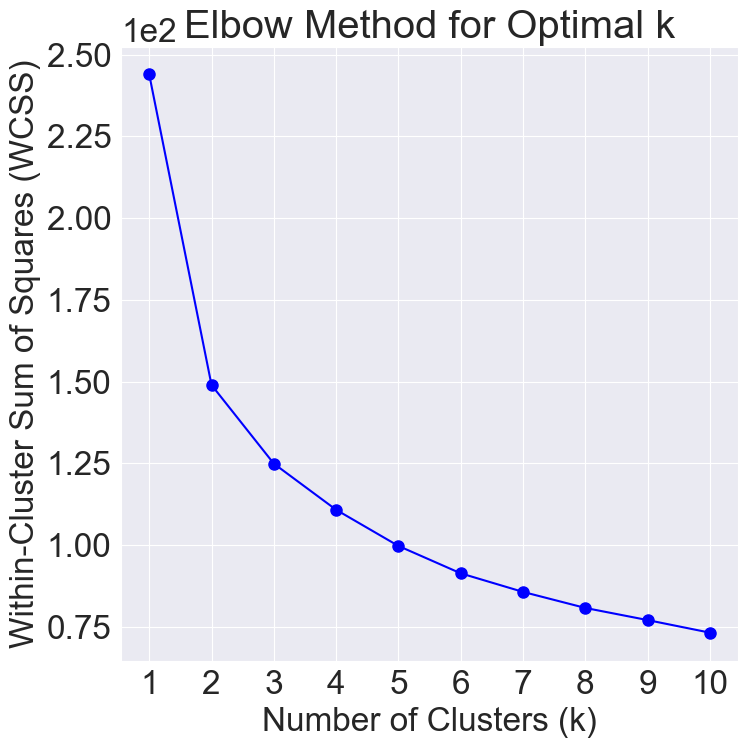

In [25]:
# Calculate the within-cluster sum of squares (WCSS) for different values of k
wcss = []
k_values = range(1, 11)  # Test k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gene_medians_normalized.T)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for the k-means

# Plot the results to visualize the Elbow Method
plt.figure(figsize=(8, 8))
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

plt.grid(True)
plt.tight_layout()

plt.savefig(rf'{output_dir}\elbow.png', dpi = 500)


In [36]:

plt.rcParams.update({'font.size': 24})  # Adjust the size as needed

# Define the colormap
cmap = cm.get_cmap('Dark2')  # You can change 'viridis' to any other colormap

# Map Cluster 0 to Cluster 4
gene_clusters['cluster'] = gene_clusters['cluster'].replace({0: 6})

# Generate unique colors for each cluster
cluster_unique = np.sort(gene_clusters['cluster'].unique())  # Sort clusters
colors = cmap(np.linspace(0, 1, len(cluster_unique)))
cluster_colors = dict(zip(cluster_unique, colors))

# # Print the color codes
# for cluster, color in cluster_colors.items():
#     print(f"Cluster {cluster}: Color code {color}")

plt.figure(figsize=(14, 14))

# Plot individual gene expression vectors with low alpha
for cluster in cluster_unique:
    cluster_genes = gene_clusters[gene_clusters['cluster'] == cluster]['gene'].values
    color = cluster_colors[cluster]

    for gene in cluster_genes:
        plt.plot(gene_medians.index, gene_medians_normalized[gene], color=color, alpha=0.17)

# Plot the mean expression vector for each cluster with a higher alpha and thicker line
for cluster in cluster_unique:
    cluster_genes = gene_clusters[gene_clusters['cluster'] == cluster]['gene'].values
    color = cluster_colors[cluster]

    # Calculate the mean expression vector for the cluster
    mean_expression = gene_medians_normalized[cluster_genes].median(axis=1)

    # Plot the mean expression vector
    plt.plot(gene_medians.index, mean_expression, label=f'Cluster {cluster}', color=color, alpha=1, linewidth=3.5)

plt.ylim(0.5,2.5)
plt.title('Combined Overlay of Gene Expression Vectors by Cluster')
plt.xlabel('Cell Length Bins')
plt.ylabel('Expression Level (Scaled & Min-Subtracted)')
plt.legend(loc='upper right', fontsize='medium', ncol=1)

# Save the combined overlay plot
combined_overlay_plot_path = os.path.join(output_dir, 'combined_cluster_overlay.png')
plt.savefig(combined_overlay_plot_path, dpi=600)
plt.close()


Cluster 1: Color code [0.10588235 0.61960784 0.46666667 1.        ]
Cluster 2: Color code [0.45882353 0.43921569 0.70196078 1.        ]
Cluster 3: Color code [0.4        0.65098039 0.11764706 1.        ]
Cluster 4: Color code [0.65098039 0.4627451  0.11372549 1.        ]
Cluster 6: Color code [0.4 0.4 0.4 1. ]


In [27]:
gene_clusters.to_csv(fr'{output_dir}\clustered_genes.csv')


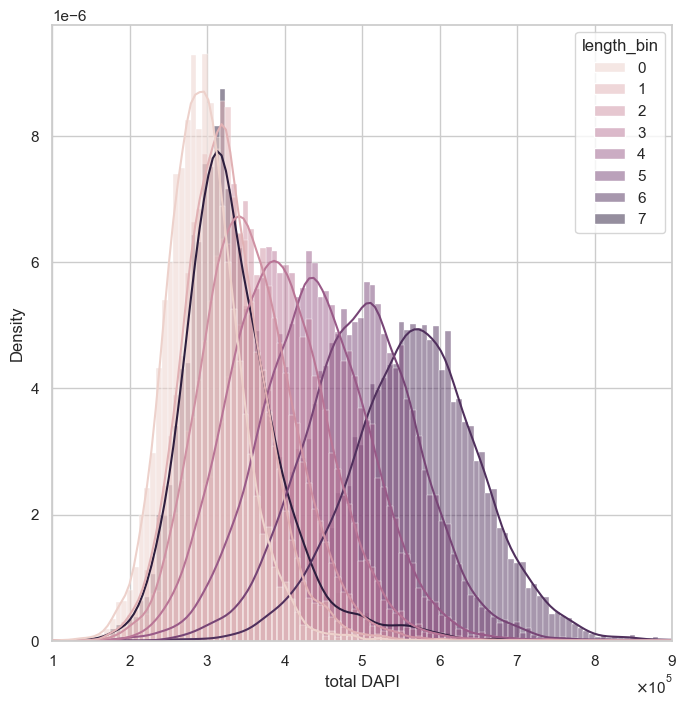

In [111]:

for_plot = df_norm.merge(dapi_df, on=['cell_id','field_of_view'], how='left')  # Replace 'cell_id' with actual key colum
plt.figure(figsize=(8, 8))

sns.histplot(
    for_plot, x="total", hue="length_bin",
    stat="density", common_norm=False, kde=True
)
plt.xlim(1e5, 9e5)
plt.xlabel('total DAPI')
# Use ScalarFormatter to format the x-axis labels with scientific notation
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Adjust power limits if necessary
plt.gca().xaxis.set_major_formatter(formatter)

# Save the figure
plt.savefig(r'C:\Users\yedidyab\Downloads\hist_dapi_bin', dpi=500)


Plot saved successfully at C:\Users\yedidyab\Downloads\dapi.png


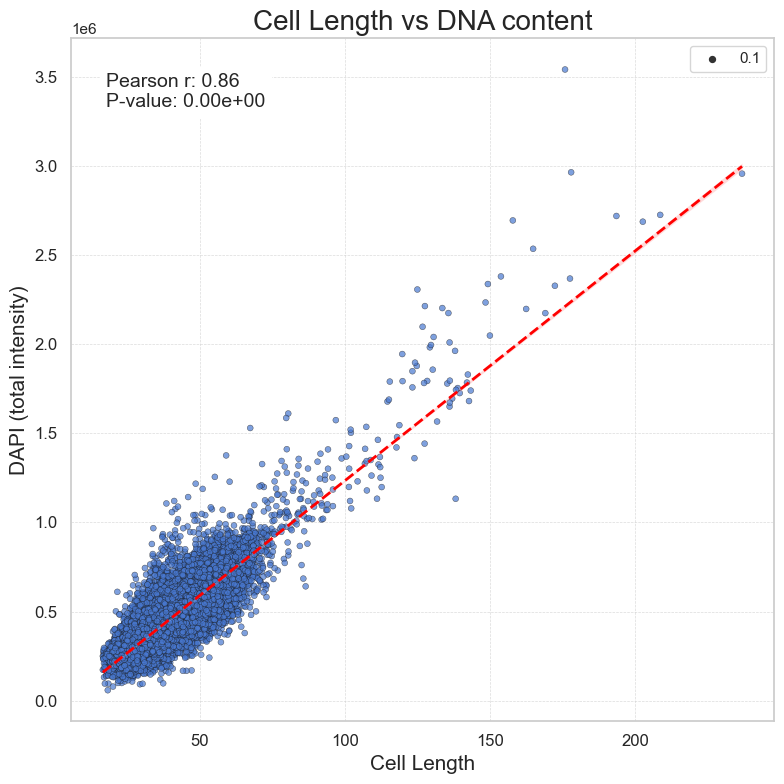

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(df_all['cell_length'], df_all['total'])

# Set the style and color palette
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(8, 8))
scatter = sns.scatterplot(
    data=df_all,
    x='cell_length',
    y='total',
    palette='viridis',  # Use a vibrant colormap
    alpha=0.7,  # Set transparency for better overlap visualization
    edgecolor='k',  # Add a black edge to make points stand out
    size=.1
)

# Add a trend line using linear regression
sns.regplot(
    data=df_all,
    x='cell_length',
    y='total',
    scatter=False,
    color='red',
    line_kws={"linewidth": 2, "linestyle": '--'}
)

# Customize the axes and title
plt.title("Cell Length vs DNA content", fontsize=20)
plt.xlabel("Cell Length", fontsize=15)
plt.ylabel("DAPI (total intensity)", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate with Pearson correlation coefficient and p-value
plt.annotate(f'Pearson r: {pearson_corr:.2f}\nP-value: {p_value:.2e}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=14, backgroundcolor='white',
             ha='left', va='top')

# Add grid and adjust the grid's appearance
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Ensure the directory exists before saving
save_path = r'C:\Users\yedidyab\Downloads\dapi.png'
directory = os.path.dirname(save_path)
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the plot before showing it
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.savefig(save_path, dpi=500)

# Optionally show the plot after saving
# plt.show()

print(f"Plot saved successfully at {save_path}")


Missing file for FOV: fov_27
Missing file for FOV: fov_27
Missing file for FOV: fov_27
Missing file for FOV: fov_27
Missing file for FOV: fov_27


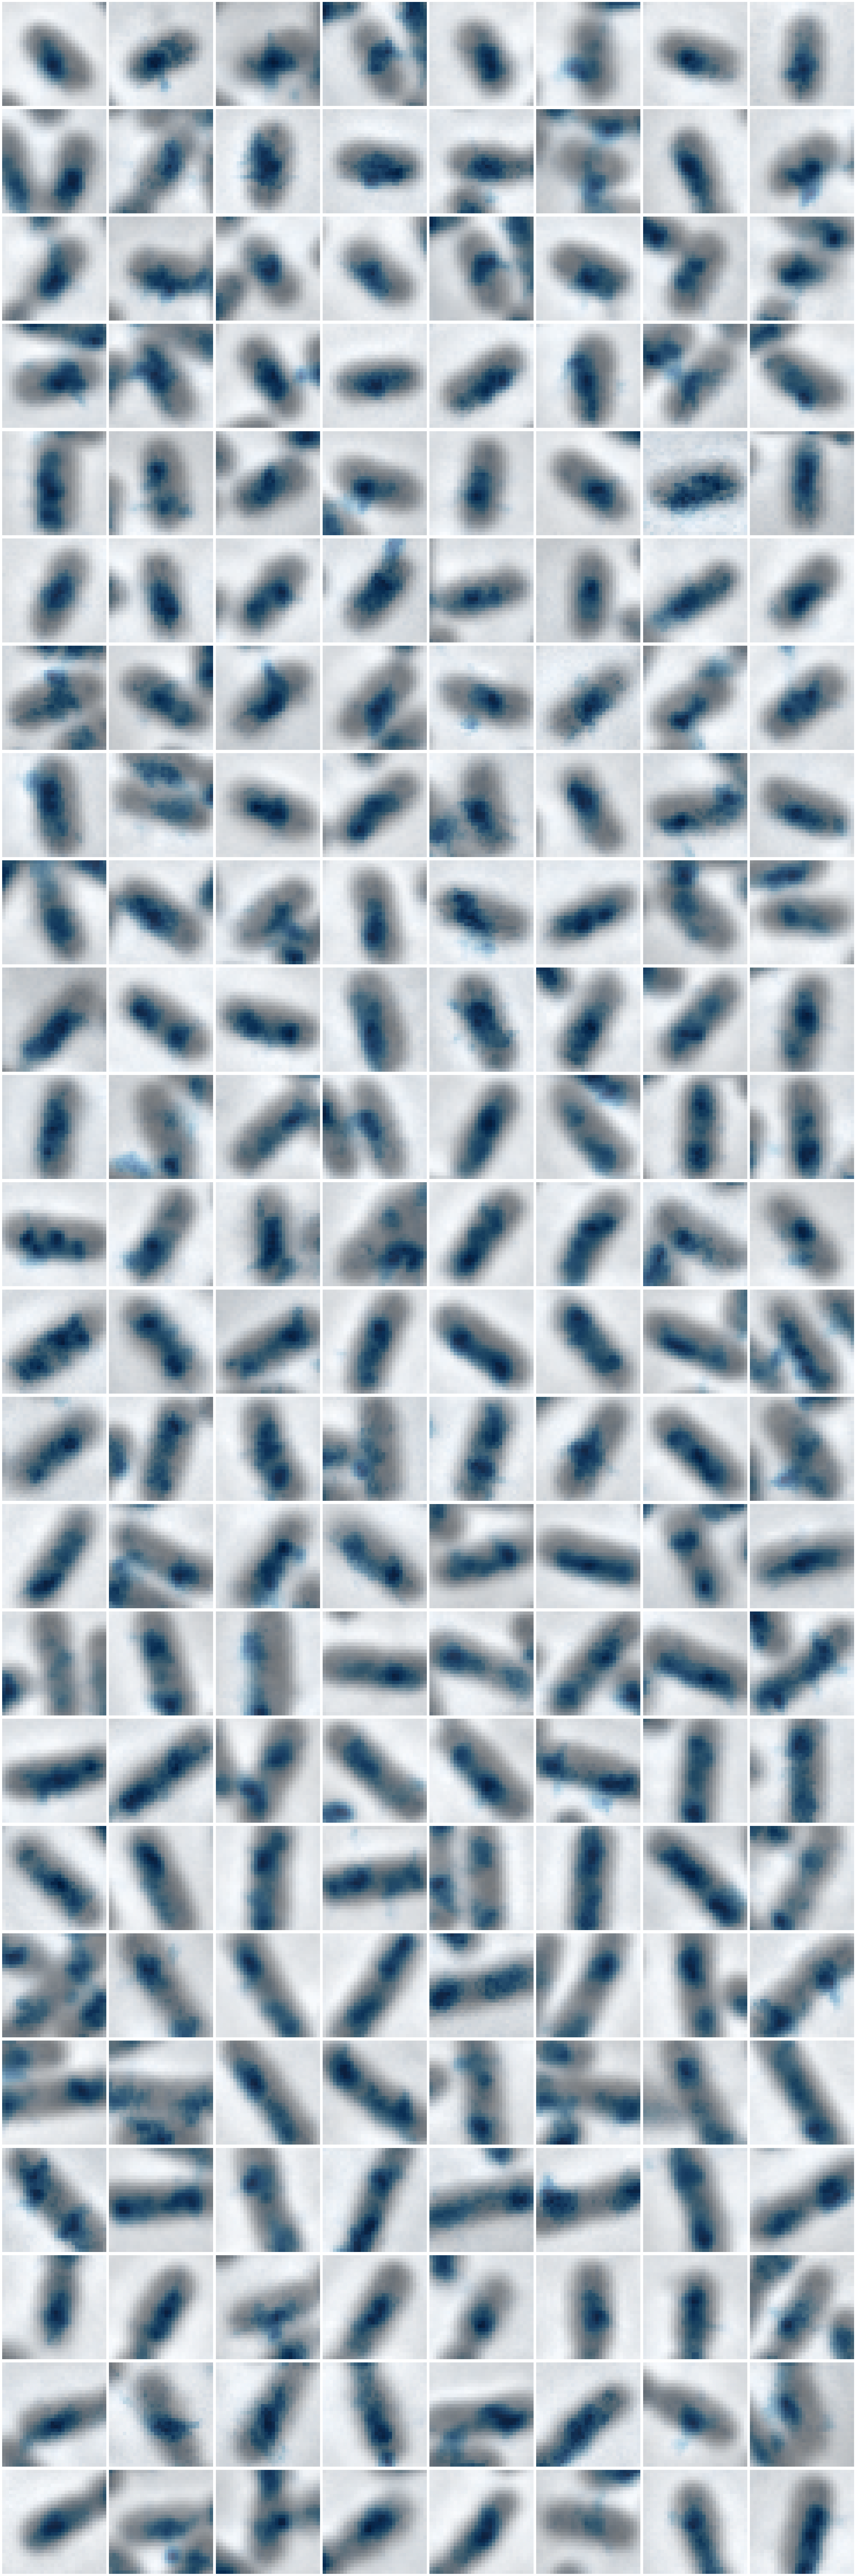

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
# Load the Excel file
file_path = r'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\automation_design\\all_libs_summary.xlsx'
# Load the Excel files
df = pd.read_excel(file_path, sheet_name='Sheet1')

automation_file_path = r'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\automation_design\\automation_summary.xlsx'
automation_df = pd.read_excel(automation_file_path, sheet_name='auto_design')

def get_lib_channel_readout_hyb(gene_name):
    # Search for the gene name in the lib_ columns
    for column in df.filter(like='lib_').columns:
        gene_row = df[df[column] == gene_name]
        if not gene_row.empty:
            channel = gene_row['channel'].values[0]
            lib = column
            readout = gene_row['readout'].values[0]

            # Find the hyb value from the automation summary
            hyb_row = automation_df[(automation_df['A647'] == readout) |
                                    (automation_df['A488'] == readout) |
                                    (automation_df['A550'] == readout)]
            if not hyb_row.empty:
                hyb = hyb_row['hyb'].values[0]
            else:
                hyb = "Hyb not found"

            return {
                'gene': gene_name,
                'channel': channel,
                'lib': lib,
                'readout': readout,
                'hyb': hyb
            }

    return f"Gene {gene_name} not found in the dataset."


# Function to determine colormap based on channel wavelength
def get_cmap(channel):
    if channel == 'A488':
        return 'Greens'
    elif channel == 'A550':
        return 'Reds'
    elif channel == 'A647':
        return 'Blues'
    else:
        return 'gray'  # default colormap


def plot_gene_images_by_length_bin(df, img_dir, seg_dir, gene_name, bins=8, images_per_bin=24, box_size=30):
    # Filter the DataFrame for the given gene
    gene_df = df.dropna(subset=[gene_name])

    # Get the hybridization and channel information
    hyb_info = get_lib_channel_readout_hyb(gene_name)
    hyb = hyb_info['hyb']
    channel = hyb_info['channel']
    channel = 'dapi'
    cmap = get_cmap(channel)
    cmap = 'Blues'

    fig, axes = plt.subplots(images_per_bin, bins, figsize=(bins * 5, images_per_bin * 5))
    axes = axes.ravel()

    for bin_idx in range(bins):
        # Filter for the current length bin
        bin_df = gene_df[gene_df['length_bin'] == bin_idx]

        # Randomly sample up to 24 rows
        sampled_df = bin_df.sample(n=min(images_per_bin * 2, len(bin_df)), random_state=42)  # Sampling extra for fallback

        img_count = 0  # Counter for valid images

        for img_idx, (i, row) in enumerate(sampled_df.iterrows()):
            if img_count >= images_per_bin:
                break

            fov = row['field_of_view']  # Update this if your df has different column names
            idx = row['cell_id']  # Assuming the index column is named 'idx'

            # Construct file paths
            img_file = os.path.join(img_dir, f"{fov}_hyb_{hyb}.{channel}.tif")
            phase_file = os.path.join(img_dir, f"{fov}_hyb_{hyb}.phase.tif")
            seg_file = os.path.join(seg_dir, f"{fov}_hyb_1", f"{fov}_hyb_1.seg.npy")

            if not os.path.exists(img_file) or not os.path.exists(phase_file) or not os.path.exists(seg_file):
                print(f"Missing file for FOV: {fov}")
                continue

            img = io.imread(img_file, as_gray=True)
            phase_img = io.imread(phase_file, as_gray=True)
            seg = np.load(seg_file)

            # Get bounding box
            def get_bounding_box(seg, idx, box_size):
                y, x = np.where(seg == idx)
                if len(x) == 0 or len(y) == 0:
                    return None
                x_center, y_center = int(np.mean(x)), int(np.mean(y))
                x_min = max(0, x_center - box_size // 2)
                x_max = min(seg.shape[1], x_center + box_size // 2)
                y_min = max(0, y_center - box_size // 2)
                y_max = min(seg.shape[0], y_center + box_size // 2)
                return x_min, x_max, y_min, y_max

            bbox = get_bounding_box(seg, idx, box_size)
            if bbox is None:
                print(f"Bounding box not found for idx: {idx}")
                continue

            # Crop the image
            x_min, x_max, y_min, y_max = bbox
            cropped_img = img[y_min:y_max, x_min:x_max]
            cropped_phase_img = phase_img[y_min:y_max, x_min:x_max]

            if cropped_img.size == 0 or cropped_phase_img.size == 0:
                print(f"Empty cropped image for FOV: {fov}, idx: {idx}")
                continue

            ax = axes[bin_idx * images_per_bin + img_count]
            ax.imshow(cropped_phase_img, cmap='gray')  # Background phase image
            ax.imshow(cropped_img, cmap=cmap, alpha=0.5)  # Overlay gene channel image
            # ax.set_title(f"FOV: {fov}, Bin: {bin_idx}, ID: {idx}")
            ax.axis('off')

            img_count += 1  # Increment only if a valid image is found

    plt.tight_layout()
    plt.savefig(rf'C:\Users\yedidyab\Downloads\beehive.png')







# Example usage
img_dir = r'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\image_projections'
seg_dir = r'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation'
plot_gene_images_by_length_bin(df_norm, img_dir,seg_dir, 'fimA')
